# Données spatiales: découverte de geopandas

<p class="badges">

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABmanipulation%2003_geopandas_tutorial%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=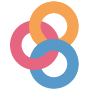" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

</p>

</p>

Dans ce tutoriel, nous allons utiliser les données suivantes :

-   [Localisations des stations velib](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr)
-   [Carte des limites administratives françaises](https://www.data.gouv.fr/fr/datasets/decoupage-administratif-communal-francais-issu-d-openstreetmap/)
-   [Arrondissements parisiens](https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr)

La représentation des données, notamment la cartographie, est présentée plus
amplement dans la partie [visualiser](#visualiser). Quelques méthodes
pour faire rapidement des cartes seront présentées ici,mais
l’objet de ce chapitre porte davantage sur la manipulation des données géographiques.

Ce tutoriel s’inspire beaucoup d’un autre tutoriel que j’ai fait pour
`R` disponible
[dans la documentation `utilitr`](https://www.book.utilitr.org/spatdata.html).
Il peut servir de pendant à celui-ci pour l’utilisateur de `R`.

Quelques installations préalables sont nécessaires :

``` python
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
```

Pour être en mesure d’exécuter ce tutoriel, les imports suivants
seront utiles.

In [2]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Données spatiales: quelle différence avec des données traditionnelles ?

**Le terme “données spatiales” désigne les données qui portent sur les caractéristiques géographiques des objets (localisation, contours, liens)**. Les caractéristiques géographiques des objets sont décrites à l’aide d’un **système de coordonnées**
qui permettent une représentation dans un espace euclidien ($(x,y)$).
Le passage de l’espace réel (la Terre, qui est une sphère) à l’espace plan
se fait grâce à un **système de projection**. Voici quelques exemples
de données spatiales :

-   Une table décrivant des bâtiments, avec les coordonnées géographiques de chaque bâtiment;
-   Le découpage communal du territoire, avec le contour du territoire de chaque commune;
-   Les routes terrestres, avec les coordonnées décrivant leur parcours.

Les données spatiales rassemblent classiquement deux types de données :

1.  des **données géographiques** (ou géométries): objets géométriques tels que des points, des vecteurs, des polygones, ou des maillages (*raster*). Exemple: la forme de chaque chaque commune, les coordonnées d’un bâtiment;
2.  des **données attributaires** (ou attributs): des mesures et des caractéristiques associés aux objets géométriques. Exemple: la population de chaque commune, le nombre de fenêtres et le nombre d’étages d’un bâtiment.

**Les données spatiales sont fréquemment traitées à l’aide d’un système d’information géographique (SIG)**, c’est-à-dire un système d’information capable de stocker, d’organiser et de présenter des données alphanumériques spatialement référencées par des coordonnées dans un système de référence (CRS). `Python` dispose de fonctionnalités lui permettant de réaliser les mêmes tâches qu’un SIG (traitement de données spatiales, représentations cartographiques).

**Les systèmes de projection font l’objet de standards internationaux et sont souvent désignés par des codes dits codes EPSG**. Ce [site](https://epsg.io/) est un bon aide-mémoire. Les plus fréquents, pour les utilisateurs français, sont les suivants (plus d’infos [ici](https://geodesie.ign.fr/contenu/fichiers/documentation/SRCfrance.pdf)):

-   `2154`: système de projection Lambert 93. Il s’agit du système de projection officiel. La plupart des données diffusées par l’administration pour la métropole sont disponibles dans ce système de projection.
-   `27572`: Lambert II étendu. Il s’agit de l’ancien système de projection officiel. Les données spatiales anciennes peuvent être dans ce format.
-   `4326`: WGS 84 ou système de pseudo-Mercator. Attention, ce n’est en réalité pas un système de projection mais un système de coordonnées (longitude / latitude) qui permet simplement un repérage angulaire sur l’ellipsoïde. Il est utilisé pour les données GPS.

## De `pandas` à `geopandas`

Le *package* `geopandas` est une boîte à outils conçue pour faciliter la manipulation de données spatiales. **La grande force de `geopandas` est qu’il permet de manipuler des données spatiales comme s’il s’agissait de données traditionnelles**, car il repose sur le standard ISO 19125 [*simple feature access*](https://en.wikipedia.org/wiki/Simple_Features) défini conjointement par l’*Open Geospatial Consortium (OGC)* et l’*International Organization for Standardization (ISO)*.

Par rapport à un DataFrame standard, un objet `geopandas` comporte
une colonne supplémentaire: `geometry`. Elle stocke les coordonnées des
objets géographiques (ou ensemble de coordonnées s’agissant de contours). Un objet `geopandas` hérite des propriétés d’un
DataFrame pandas mais propose des méthodes adaptées au traitement des données spatiales.

Ainsi, grâce à `geopandas`, on pourra effectuer des manipulations sur les attributs des données comme avec `pandas` mais on pourra également faire des manipulations sur la dimension spatiale des données. En particulier,

-   Calculer des distances et des surfaces;
-   Agréger rapidement des zonages (regrouper les communes en département par exemple);
-   Trouver dans quelle commune se trouve un bâtiment à partir de ses coordonnées géographiques;
-   Recalculer des coordonnées dans un autre système de projection.
-   Faire une carte, rapidement et simplement

<div class="alert alert-warning" role="alert">

Les manipulations de données sur un objet geopandas sont nettement plus lentes que sur un DataFrame traditionnel (car python doit gérer les informations géographiques pendant la manipulation des données). Lorsque vous manipulez des données de grandes dimensions, il peut être préférable d’effectuer les opérations sur les données avant de joindre une géométrie à celles-ci.

</div>

Par rapport à un logiciel spécialisé comme `QGIS`, `python` permettra
d’automatiser le traitement et la représentation des données. D’ailleurs,
`QGIS` utilise lui-même `python`…

# Importer des données spatiales

Les données spatiales sont plus riches que les données traditionnelles car elles
incluent, habituellement, des éléments supplémentaires pour placer dans
un espace cartésien les objets. Cette dimension supplémentaire peut être simple
(un point comporte deux informations supplémentaire: $x$ et $y$) ou
assez complexe (polygones, lignes avec direction, etc.)

Les formats les plus communs de données spatiales sont les suivants :

-   *shapefile* (`.shp`): format (**propriétaire**) le plus commun de données géographiques.
    La table de données (attributs) est stockée dans un fichier séparé des
    données spatiales. En faisant `geopandas.read_file("monfichier.shp")`, le
    package fait lui-même le lien entre les observations et leur représentation spatiale ;
-   *geopackage* (`.gpkg`) : ce (relativement) nouveau format **libre** en un seul fichier également (lui recommandé par l’OGC) vise progressivement à se substituer au shapefile. Il est par exemple le format par défaut dans QGIS.
-   *geojson* (`.json`) : ce format, non préconisé par l’OGC est largement utilisé pour le développement web comme dans la librairie `leaflet`. La dimension spatiale est stockée dans le même fichier que les attributs. Ces fichiers sont généralement beaucoup plus légers que les *shapefiles* mais possèdent des limites s’agissant de gros jeux de données.

Cette [page](https://si.ecrins-parcnational.com/blog/2020-02-geojson-shapefile-geopackage.html) compare plus en détail ces trois types de formats de données géographiques.

L’aide de [geopandas](https://geopandas.org/io.html) propose des bouts de code en fonction des différentes situations dans lesquelles on se trouve.

### Exemple: récupérer les découpages territoriaux

L’un des fonds de carte les plus fréquents qu’on utilise est celui des
limites administratives. Elles peuvent être trouvées sur le
[site de l’IGN](https://geoservices.ign.fr/adminexpress#telechargementCog) ou récupérées sur
[data.gouv](https://www.data.gouv.fr/fr/datasets/decoupage-administratif-communal-francais-issu-d-openstreetmap/) (construites par `openstreetmap`).
Il est également possible d’utiliser l’une des [API de l’IGN](https://api.gouv.fr/les-api/api_carto_cadastre)
mais ces dernières ne sont pas encore très documentées pour des utilisateurs
de `Python`.

Le package `pynsee` propose notamment un module dédié à la récupération de fonds de carte officiels pour valoriser des données
d’open data. L’API sur laquelle il repose étant parfois lente, nous présentons le code dédié uniquement en annexe.

Nous allons ici utiliser les données de
`data.gouv`.
L’inconvénient est que les arrondissements
parisiens ne sont pas présents dans le fichier proposé sur `data.gouv`. Il
faut donc utiliser une source complémentaire, issue de l’*opendata* de la
Mairie de Paris.

Les données des limites administratives demandent donc un peu de travail pour être
importées car elles sont zippées (mais c’est un bon exercice !). Le code suivant, dont les
détails apparaîtront plus clairs après la lecture de la partie
*[webscraping](webscraping)* permet de :

1.  Télécharger les données avec `requests` dans un dossier temporaire
2.  Les dézipper avec le module `zipfile`

La fonction suivante automatise un peu le processus :

In [3]:
import requests
import tempfile
import zipfile

url = 'https://www.data.gouv.fr/fr/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165'
temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open("{}/{}.zip".format(dirname, destname), 'wb').write(myfile.content)
  with zipfile.ZipFile("{}/{}.zip".format(dirname, destname), 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

In [4]:
download_unzip(url)

In [5]:
shp_communes = gpd.read_file(temporary_location + "/borders/communes-20220101.shp")

In [6]:
shp_communes.head()

insee 
 nom 
 wikipedia 
 surf_ha 
 geometry 
 
 
 
 
 0 
 2B222 
 Pie-d'Orezza 
 fr:Pie-d'Orezza 
 573.0 
 POLYGON ((9.32017 42.38507, 9.32028 42.38510, ... 
 
 
 1 
 2B137 
 Lano 
 fr:Lano 
 824.0 
 POLYGON ((9.20010 42.39013, 9.20014 42.39014, ... 
 
 
 2 
 2B051 
 Cambia 
 fr:Cambia 
 833.0 
 POLYGON ((9.27757 42.37509, 9.27758 42.37512, ... 
 
 
 3 
 2B106 
 Érone 
 fr:Érone 
 393.0 
 POLYGON ((9.25119 42.37605, 9.25132 42.37603, ... 
 
 
 4 
 2B185 
 Oletta 
 fr:Oletta 
 2674.0 
 POLYGON ((9.28340 42.66273, 9.28345 42.66273, ...

On reconnaît la structure d’un `DataFrame` `pandas`. A cette structure s’ajoute
une colonne `geometry` qui enregistre la position des limites des polygones de chaque
observation.

Comme vu précédemment, le système de projection est un élément important. Il permet à `Python`
d’interpréter les valeurs des points (deux dimensions) en position sur
la terre, qui n’est pas un espace plan.

In [7]:
shp_communes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Ici, les données ne sont pas projetées puisqu’elles sont dans le
système WSG84 (epsg: 4326) ce qui permet de facilement ajouter
un fonds de carte `Openstreetmap` ou `Stamen` pour rendre une représentation
graphique plus esthétique.
En toute rigueur, pour faire une carte statique d’un pays en particulier,
il faudrait reprojeter les données dans un système de projection adapté à la zone géographique étudiée
(par exemple le Lambert-93 pour la France métropolitaine).

On peut ainsi représenter Paris pour se donner une idée de la nature
du shapefile utilisé :

<AxesSubplot:>

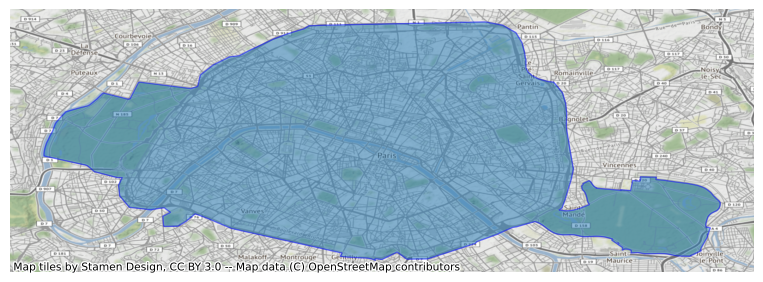

In [8]:
paris = shp_communes.loc[shp_communes['insee'].str.startswith("75")]

fig,ax = plt.subplots(figsize=(10, 10))
paris.plot(ax = ax, alpha=0.5, edgecolor='blue')
ctx.add_basemap(ax, crs = paris.crs.to_string())
ax.set_axis_off()
ax

On voit ainsi que les données pour Paris ne comportent pas d’arrondissement,
ce qui est limitant pour une analyse focalisée sur Paris. On va donc les
récupérer sur le site d’open data de la ville de Paris et les substituer
à Paris :

En refaisant la carte ci-dessus, on obtient bien, cette fois, le résultat
espéré

<AxesSubplot:>

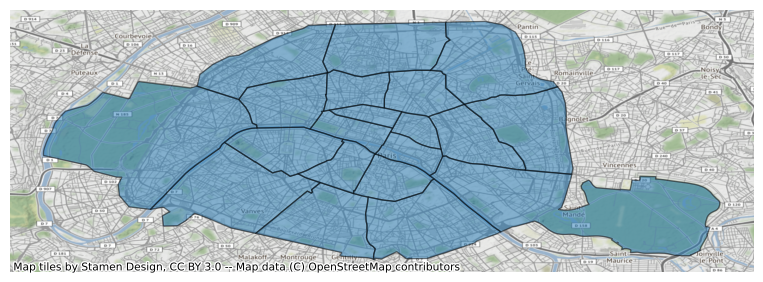

In [10]:
paris = shp_communes.loc[shp_communes.insee.str.startswith("75")]

fig,ax = plt.subplots(figsize=(10, 10))

paris.plot(ax = ax, alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs = paris.crs.to_string())
ax.set_axis_off()
ax

# Opérations sur les attributs et les géométries

## Import des données velib

Souvent, le découpage communal ne sert qu’en fond de cartes, pour donner des
repères. En complément de celui-ci, on peut désirer exploiter
un autre jeu de données. On va partir des données de localisation des
stations velib,
disponibles [sur le site d’open data de la ville de Paris](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/table/) et
requêtables directement par l’url
<https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr>

In [11]:
velib_data = 'https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr'
stations = gpd.read_file(velib_data)
stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
shp_communes['dep'] = shp_communes.insee.str[:2]

On peut se rassurer en affichant les données sur la carte des communes d’Île-de-France.

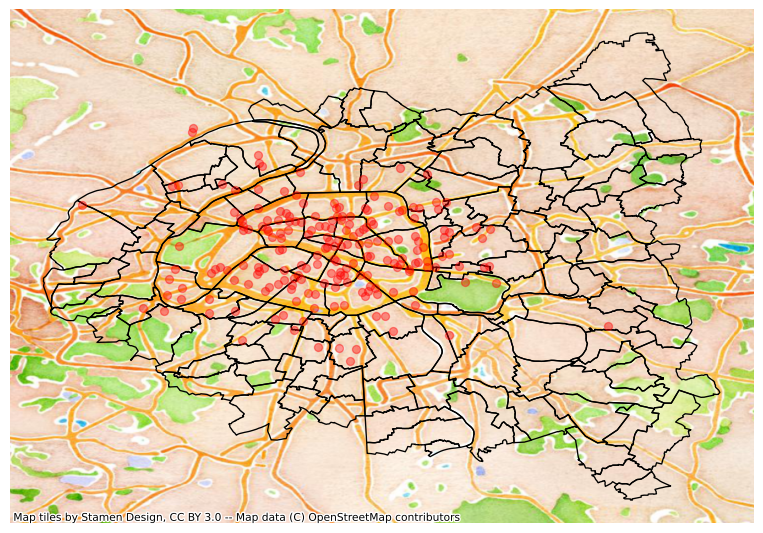

In [13]:
fig,ax = plt.subplots(figsize=(10, 10))
stations.sample(200).plot(ax = ax, color = 'red', alpha = 0.4, zorder=2)
shp_communes[shp_communes['dep'].isin(['75','92','93','94'])].plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, crs = stations.crs.to_string(), source = ctx.providers.Stamen.Watercolor)
ax.set_axis_off()

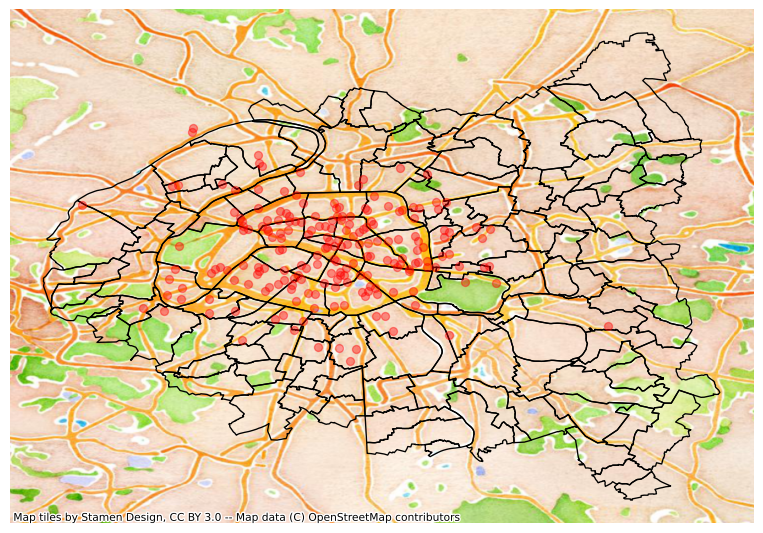

In [15]:
fig = ax.get_figure()
fig.savefig("featured.png")

Découvrez ci-dessous par étape les différentes lignes de commandes permettant d’afficher cette carte complète,
étape par étape :

:one:
Afficher le nuage de points de 200 stations vélibs prises au hasard

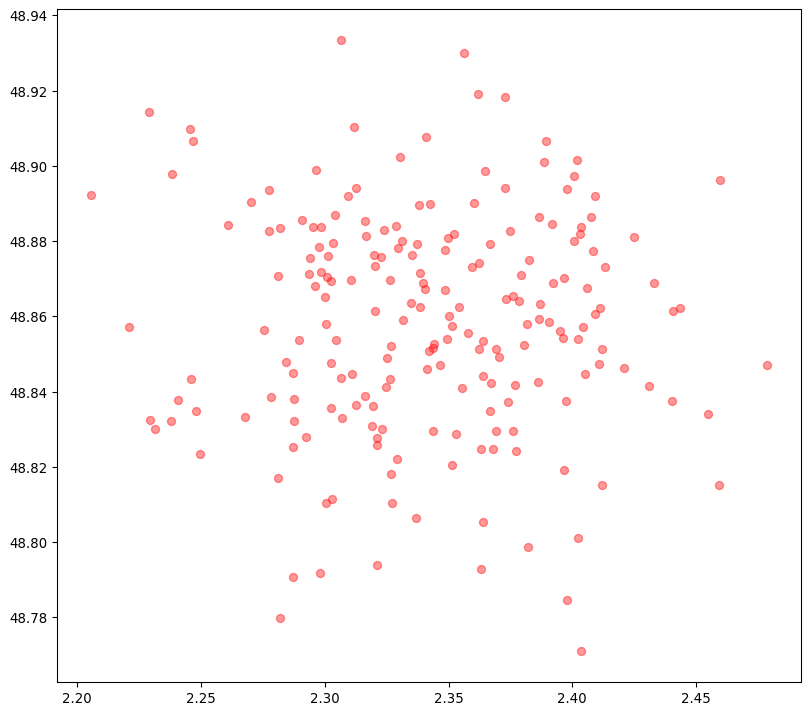

:two:
Ajouter à cette couche, en-dessous, les contours des communes

:three:
Ajouter un fond de carte de type *open street map* grâce au package
`contextily`

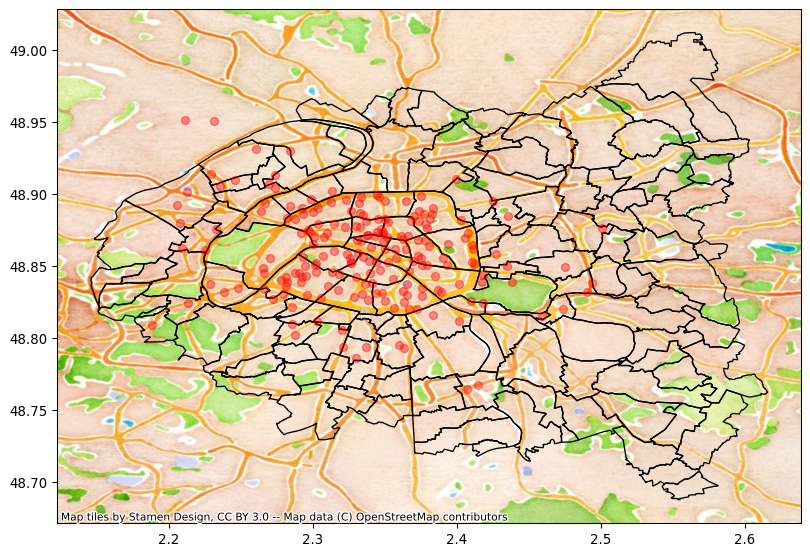

:four:
Il ne reste plus qu’à retirer l’axe des coordonnées, qui n’est pas très
esthétique.

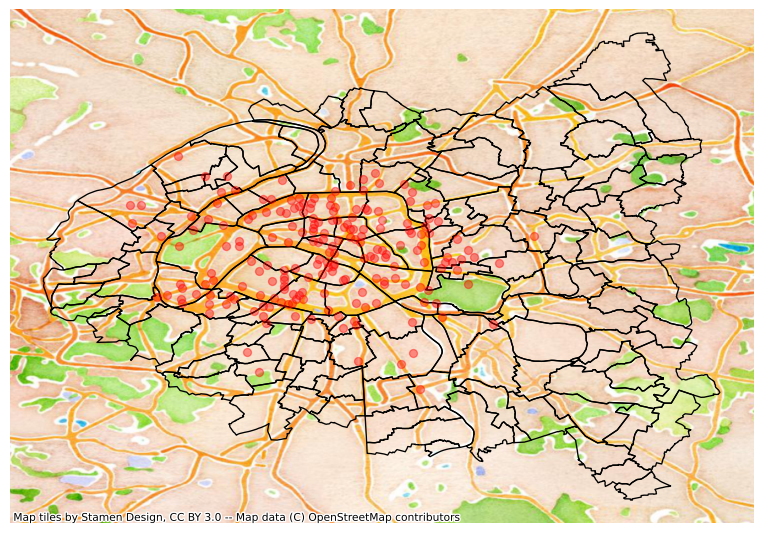

*In fine*, on obtient la carte désirée.

## Opérations sur les attributs

Toutes les opérations possibles sur un objet `pandas` le sont également
sur un objet `geopandas`. Pour manipuler les données, et non la géométrie,
on parlera d’opérations sur les attributs.

Par exemple, si on désire
connaître quelques statistiques sur la taille des stations:

In [24]:
stations.describe()

capacity 
 
 
 
 
 count 
 1441.000000 
 
 
 mean 
 31.246357 
 
 
 std 
 11.977744 
 
 
 min 
 0.000000 
 
 
 25% 
 23.000000 
 
 
 50% 
 29.000000 
 
 
 75% 
 37.000000 
 
 
 max 
 74.000000

Pour connaître les plus grands départements, créons d’abord les deux variables en question :

-   le département (deux premiers chiffres du code Insee)
-   la surface (méthode `area` sur un objet `geopandas.GeoDataFrame` ramenée en km², attention néamoins au système de projection comme cela est expliqué plus bas)

In [25]:
shp_communes['dep'] = shp_communes.insee.str[:2]
shp_communes['surface'] = shp_communes.area.div(10**6)

/tmp/ipykernel_383/3567164703.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Les plus grands départements s’obtiennent par une agrégation des
surfaces communales :

In [26]:
shp_communes.groupby('dep').sum().sort_values('surface', ascending = False)

surf_ha 
 c_ar 
 surface 
 n_sq_co 
 n_sq_ar 
 perimetre 
 
 
 dep 
 
 
 
 
 
 
 
 
 
 
 97 
 8919019.0 
 0.0 
 7.285587e-06 
 0.000000e+00 
 0.000000e+00 
 0.000000 
 
 
 33 
 1008656.0 
 0.0 
 1.147974e-06 
 0.000000e+00 
 0.000000e+00 
 0.000000 
 
 
 24 
 922024.0 
 0.0 
 1.054448e-06 
 0.000000e+00 
 0.000000e+00 
 0.000000 
 
 
 21 
 879890.0 
 0.0 
 1.049365e-06 
 0.000000e+00 
 0.000000e+00 
 0.000000 
 
 
 40 
 935340.0 
 0.0 
 1.049146e-06 
 0.000000e+00 
 0.000000e+00 
 0.000000 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 90 
 61046.0 
 0.0 
 7.311935e-08 
 0.000000e+00 
 0.000000e+00 
 0.000000 
 
 
 94 
 24468.0 
 0.0 
 2.996316e-08 
 0.000000e+00 
 0.000000e+00 
 0.000000 
 
 
 93 
 23678.0 
 0.0 
 2.907304e-08 
 0.000000e+00 
 0.000000e+00 
 0.000000 
 
 
 92 
 17550.0 
 0.0 
 2.152066e-08 
 0.000000e+00 
 0.000000e+00 
 0.000000 
 
 
 75 
 0.0 
 210.0 
 1.291524e-08 
 1.500003e+10 
 1.500000e+10 
 190443.799631 
 
 
 
 97 rows × 6 columns

Si on veut directement les plus
grandes communes de France métropolitaine :

In [27]:
shp_communes[shp_communes.dep != "97"].sort_values('surface', ascending = False)

insee 
 nom 
 wikipedia 
 surf_ha 
 geometry 
 c_ar 
 l_aroff 
 surface 
 l_ar 
 n_sq_co 
 n_sq_ar 
 perimetre 
 dep 
 
 
 
 
 13941 
 13004 
 Arles 
 fr:Arles 
 75765.0 
 POLYGON ((4.42608 43.62325, 4.42611 43.62390, ... 
 NaN 
 NaN 
 8.438336e-08 
 NaN 
 NaN 
 NaN 
 NaN 
 13 
 
 
 2075 
 73290 
 Val-Cenis 
 fr:Val-Cenis 
 45602.0 
 POLYGON ((6.73142 45.29798, 6.73193 45.29826, ... 
 NaN 
 NaN 
 5.229354e-08 
 NaN 
 NaN 
 NaN 
 NaN 
 73 
 
 
 14809 
 13096 
 Saintes-Maries-de-la-Mer 
 fr:Saintes-Maries-de-la-Mer 
 37041.0 
 POLYGON ((4.23014 43.46047, 4.23020 43.46087, ... 
 NaN 
 NaN 
 4.122594e-08 
 NaN 
 NaN 
 NaN 
 NaN 
 13 
 
 
 33690 
 49092 
 Chemillé-en-Anjou 
 fr:Chemillé-en-Anjou 
 32137.0 
 POLYGON ((-0.86859 47.29643, -0.86833 47.29648... 
 NaN 
 NaN 
 3.816515e-08 
 NaN 
 NaN 
 NaN 
 NaN 
 49 
 
 
 16460 
 49228 
 Noyant-Villages 
 fr:Noyant-Villages 
 30102.0 
 POLYGON ((-0.02959 47.54081, -0.02958 47.54083... 
 NaN 
 NaN 
 3.595250e-08 
 NaN 
 NaN 
 NaN 
 NaN 
 49 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 33484 
 27240 
 La Ferrière-sur-Risle 
 fr:La Ferrière-sur-Risle 
 23.0 
 POLYGON ((0.78159 48.97705, 0.78160 48.97710, ... 
 NaN 
 NaN 
 2.943216e-11 
 NaN 
 NaN 
 NaN 
 NaN 
 27 
 
 
 21205 
 85134 
 Mallièvre 
 fr:Mallièvre 
 20.0 
 POLYGON ((-0.86975 46.91195, -0.86972 46.91200... 
 NaN 
 NaN 
 2.441527e-11 
 NaN 
 NaN 
 NaN 
 NaN 
 85 
 
 
 12873 
 59332 
 Lannoy 
 fr:Lannoy 
 18.0 
 POLYGON ((3.20582 50.66640, 3.20603 50.66647, ... 
 NaN 
 NaN 
 2.350093e-11 
 NaN 
 NaN 
 NaN 
 NaN 
 59 
 
 
 33085 
 95633 
 Vaudherland 
 fr:Vaudherland 
 9.0 
 POLYGON ((2.48353 49.00010, 2.48362 49.00012, ... 
 NaN 
 NaN 
 1.144269e-11 
 NaN 
 NaN 
 NaN 
 NaN 
 95 
 
 
 28820 
 33103 
 Castelmoron-d'Albret 
 fr:Castelmoron-d'Albret 
 3.0 
 POLYGON ((-0.01283 44.67966, -0.01282 44.67981... 
 NaN 
 NaN 
 3.888012e-12 
 NaN 
 NaN 
 NaN 
 NaN 
 33 
 
 
 
 34845 rows × 13 columns

Lors des étapes d’agrégation, `groupby` ne conserve pas les géométries. Autrement
dit, si on effectue, par exemple, une somme en fonction d’une variable de groupe avec
le combo `groupby(...).sum(...)` , on perd
la dimension géographique.

Il est néanmoins possible d’aggréger à la fois les géométries et les
attribus avec la méthode `dissolve`:

<AxesSubplot:>

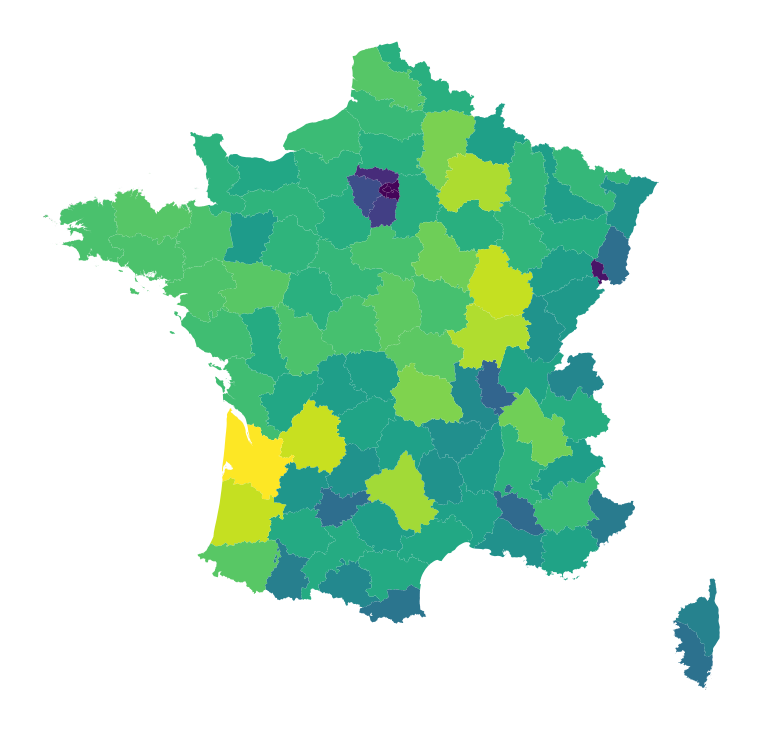

In [28]:
fig,ax = plt.subplots(figsize=(10, 10))
shp_communes[shp_communes.dep != "97"].dissolve(by='dep', aggfunc='sum').plot(ax = ax, column = "surface")
ax.set_axis_off()
ax

## Opérations sur les géométries

<div class="alert alert-danger" role="alert">

Les données sont en système de coordonnées WGS 84 ou pseudo-Mercator (epsg: `4326`) et ne sont pas projetées. C’est un format approprié lorsqu’il s’agit d’utiliser un fonds
de carte openstreetmap, stamen, google maps, etc.

Mais ce n’est pas un
format sur lequel on désire faire des calculs car les distances sont faussées sans utiliser de projection. D’ailleurs, `geopandas` refusera certaines opérations
sur des données dont le crs est `4326`. On reprojete ainsi les données
dans la projection officielle pour la métropole, le Lambert 93
(epsg: `2154`).

</div>

In [29]:
communes = shp_communes.to_crs(2154)
stations = stations.to_crs(2154)

Outre la représentation graphique simplifiée,
sur laquelle nous reviendrons ultérieurement, l’intérêt principal d’utiliser
`geopandas` est l’existence de méthodes efficaces pour
manipuler la dimension spatiale. Un certain nombre proviennent du
package
[shapely](https://shapely.readthedocs.io/en/latest/manual.html#general-attributes-and-methods).

Par exemple, on peut recalculer la taille d’une commune ou d’arrondissement
avec la méthode `area` (et diviser par $10^6$ pour avoir des $km^2$ au lieu
des $m^2$):

In [30]:
communes['superficie'] = communes.area.div(10**6)
communes

insee 
 nom 
 wikipedia 
 surf_ha 
 geometry 
 c_ar 
 l_aroff 
 surface 
 l_ar 
 n_sq_co 
 n_sq_ar 
 perimetre 
 dep 
 superficie 
 
 
 
 
 0 
 2B222 
 Pie-d'Orezza 
 fr:Pie-d'Orezza 
 573.0 
 POLYGON ((1220731.039 6163639.566, 1220739.763... 
 NaN 
 NaN 
 6.267077e-10 
 NaN 
 NaN 
 NaN 
 NaN 
 2B 
 5.752088 
 
 
 1 
 2B137 
 Lano 
 fr:Lano 
 824.0 
 POLYGON ((1210814.726 6163416.773, 1210817.799... 
 NaN 
 NaN 
 9.007491e-10 
 NaN 
 NaN 
 NaN 
 NaN 
 2B 
 8.266620 
 
 
 2 
 2B051 
 Cambia 
 fr:Cambia 
 833.0 
 POLYGON ((1217316.939 6162253.420, 1217317.229... 
 NaN 
 NaN 
 9.112940e-10 
 NaN 
 NaN 
 NaN 
 NaN 
 2B 
 8.364935 
 
 
 3 
 2B106 
 Érone 
 fr:Érone 
 393.0 
 POLYGON ((1215139.391 6162187.448, 1215150.029... 
 NaN 
 NaN 
 4.300889e-10 
 NaN 
 NaN 
 NaN 
 NaN 
 2B 
 3.947378 
 
 
 4 
 2B185 
 Oletta 
 fr:Oletta 
 2674.0 
 POLYGON ((1215252.372 6194187.789, 1215257.020... 
 NaN 
 NaN 
 2.935598e-09 
 NaN 
 NaN 
 NaN 
 NaN 
 2B 
 26.813421 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 15 
 75104 
 NaN 
 NaN 
 NaN 
 POLYGON ((653665.113 6861929.286, 653699.365 6... 
 4.0 
 Hôtel-de-Ville 
 1.961710e-10 
 4ème Ardt 
 750001537.0 
 750000004.0 
 5420.908434 
 75 
 1.600586 
 
 
 16 
 75120 
 NaN 
 NaN 
 NaN 
 POLYGON ((656928.376 6864099.214, 656933.359 6... 
 20.0 
 Ménilmontant 
 7.334659e-10 
 20ème Ardt 
 750001537.0 
 750000020.0 
 10704.940486 
 75 
 5.983446 
 
 
 17 
 75119 
 NaN 
 NaN 
 NaN 
 POLYGON ((655238.889 6866974.718, 655290.641 6... 
 19.0 
 Buttes-Chaumont 
 8.330200e-10 
 19ème Ardt 
 750001537.0 
 750000019.0 
 11253.182479 
 75 
 6.792651 
 
 
 18 
 75112 
 NaN 
 NaN 
 NaN 
 POLYGON ((656975.542 6859439.335, 656984.927 6... 
 12.0 
 Reuilly 
 1.998865e-09 
 12ème Ardt 
 750001537.0 
 750000012.0 
 24089.666298 
 75 
 16.314783 
 
 
 19 
 75116 
 NaN 
 NaN 
 NaN 
 POLYGON ((646773.062 6864505.289, 647008.983 6... 
 16.0 
 Passy 
 2.006875e-09 
 16ème Ardt 
 750001537.0 
 750000016.0 
 17416.109657 
 75 
 16.372542 
 
 
 
 34974 rows × 14 columns

Une méthode qu’on utilise régulièrement est `centroid` qui, comme son nom l’indique,
recherche le centroïde de chaque polygone et transforme ainsi des données
surfaciques en données ponctuelles. Par exemple, pour
représenter approximativement les centres des villages de la
Haute-Garonne (31), on
fera

<AxesSubplot:>

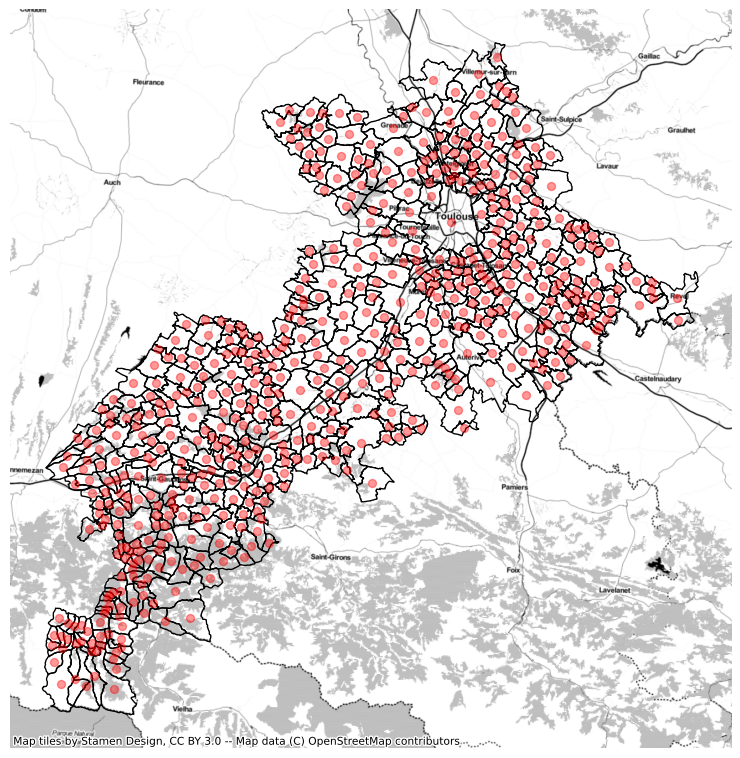

In [31]:
departement = communes[communes.dep == "31"].copy()
departement['geometry'] = departement['geometry'].centroid


ax = departement.plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
communes[communes['dep'] == "31"].plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, crs = stations.crs.to_string(), source = ctx.providers.Stamen.Toner)
ax.set_axis_off()
ax

<Figure size 672x480 with 0 Axes>

# Gérer le système de projection

Précédemment, nous avons appliqué une méthode `to_crs` pour reprojeter
les données dans un système de projection différent de celui du fichier
d’origine :

``` python
communes = communes.to_crs(2154)
stations = stations.to_crs(2154)
```

Le système de projection est fondamental pour que la dimension
spatiale soit bien interprétée par `python`. Un mauvais système de représentation
fausse l’appréciation visuelle mais peut aussi entraîner des erreurs dans
les calculs sur la dimension spatiale.
Ce [post](https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/geographic-vs-projected-coordinate-reference-systems-UTM/) propose de riches éléments sur le
sujet, notamment l’image suivante qui montre bien le principe d’une projection :

![Les différents types de projection](https://www.earthdatascience.org/images/courses/earth-analytics/spatial-data/spatial-projection-transformations-crs.png)

La Terre peut ainsi être représentée de multiples manières, ce qui n’est pas neutre sur la manière de se représenter
certains continents. En particulier, avec la projection Mercator, l’Afrique apparaît beaucoup moins vaste qu’elle ne l’est en réalité

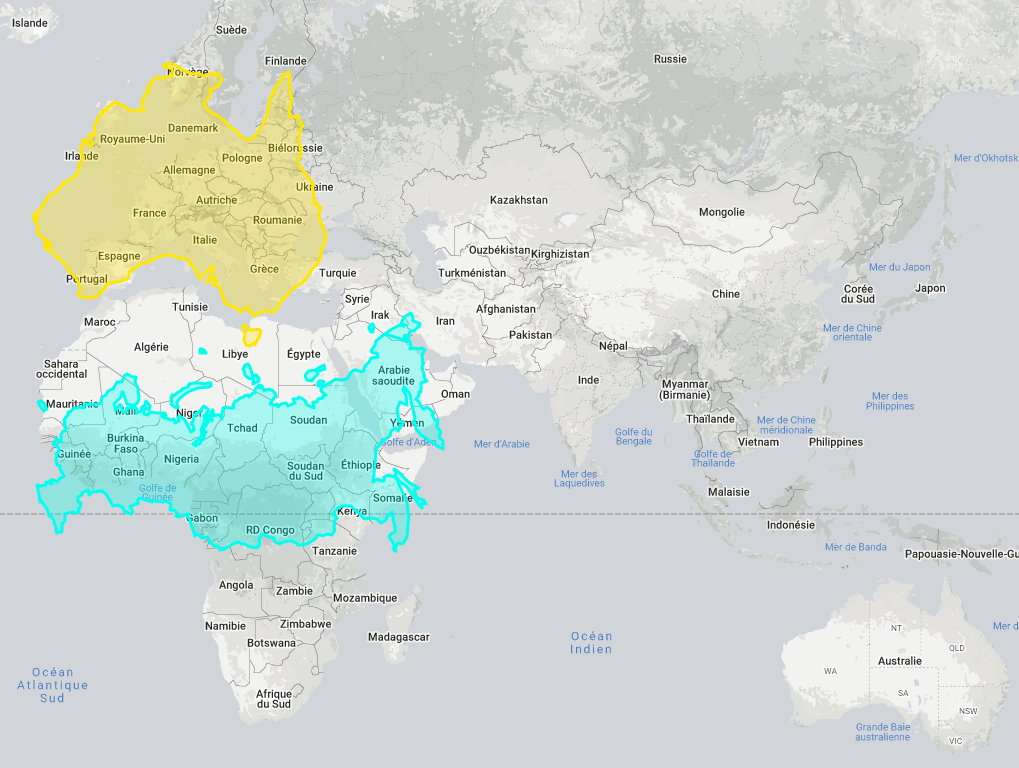
*Exemple de reprojection de pays depuis le site [thetruesize.com](https://thetruesize.com/)*

Les projections sont très nombreuses et certaines peuvent avoir une [forme suprenante](https://imgs.xkcd.com/comics/map_projections.png)

Concernant la gestion des projections avec `geopandas`,
la [documentation officielle](https://geopandas.org/projections.html) est très bien
faite. Elle fournit notamment l’avertissement suivant qu’il est
bon d’avoir en tête:

> Be aware that most of the time you don’t have to set a projection. Data loaded from a reputable source (using the geopandas.read_file() command) should always include projection information. You can see an objects current CRS through the GeoSeries.crs attribute.
>
> From time to time, however, you may get data that does not include a projection. In this situation, you have to set the CRS so geopandas knows how to interpret the coordinates.

![](https://imgs.xkcd.com/comics/bad_map_projection_south_america.png)
*Image empruntée à XKCD <https://xkcd.com/2256/> qu’on peut également trouver sur <https://blog.chrislansdown.com/2020/01/17/a-great-map-projection-joke/>*

Pour déterminer le système de projection d’une base de données, on peut vérifier l’attribut `crs`:

In [33]:
communes.crs

<Derived Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica.
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Les deux principales méthodes pour définir le système de projection utilisé sont:

-   **`df.set_crs`**: cette commande sert à préciser quel est le système de projection utilisé, c’est-à-dire comment les coordonnées *(x,y)* sont reliées à la surface terrestre. **Cette commande ne doit pas être utilisée pour transformer le système de coordonnées, seulement pour le définir**.
-   **`df.to_crs`**: **cette commande sert à projeter les points d’une géométrie dans une autre, c’est-à-dire à recalculer les coordonnées selon un autre système de projection.**

Dans le cas particulier de production de carte avec un fond `openstreetmaps` ou une carte dynamique `leaflet`, il est nécessaire de dé-projeter les données (par exemple à partir du Lambert-93) pour atterrir dans le système non-projeté WGS 84 (code EPSG 4326). Ce site [dédié aux projections géographiques](https://epsg.io/) peut-être utile pour retrouver le système de projection d’un fichier où il n’est pas indiqué.

La définition du système de projection se fait de la manière suivante (:warning: avant de le faire, se souvenir de l’avertissement !):

``` python
communes = communes.set_crs(2154)
```

Alors que la reprojection (projection Albers : 5070) s’obtient de la manière suivante :

<AxesSubplot:>

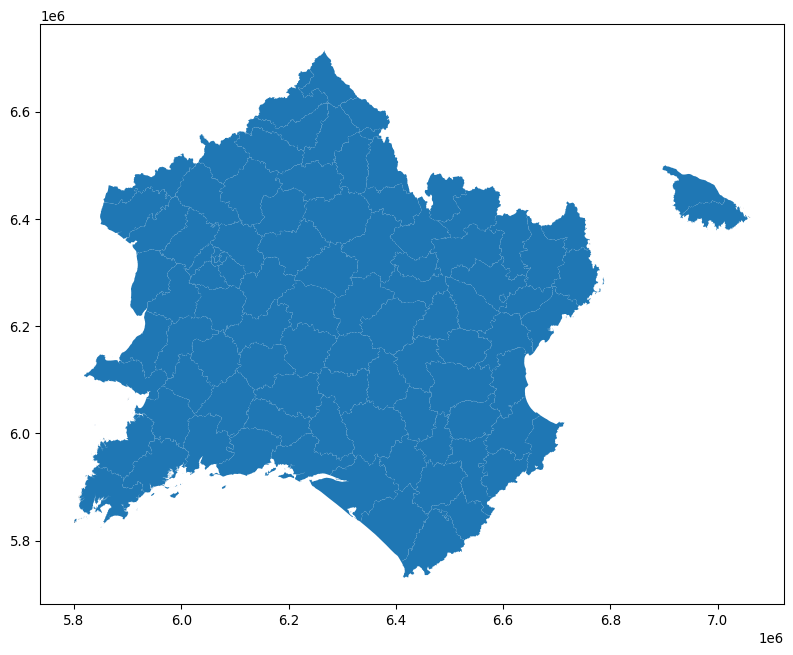

In [34]:
fig,ax = plt.subplots(figsize=(10, 10))
communes[communes.dep != "97"].dissolve(by='dep', aggfunc='sum').to_crs(5070).plot(ax = ax)
ax

<Figure size 672x480 with 0 Axes>

On le voit, cela modifie totalement la représentation de l’objet dans l’espace.
Clairement, cette projection n’est pas adaptée aux longitudes et latitudes françaises.
C’est normal, il s’agit d’une projection adaptée au continent
nord-américain (et encore, pas dans son ensemble !).

<AxesSubplot:>

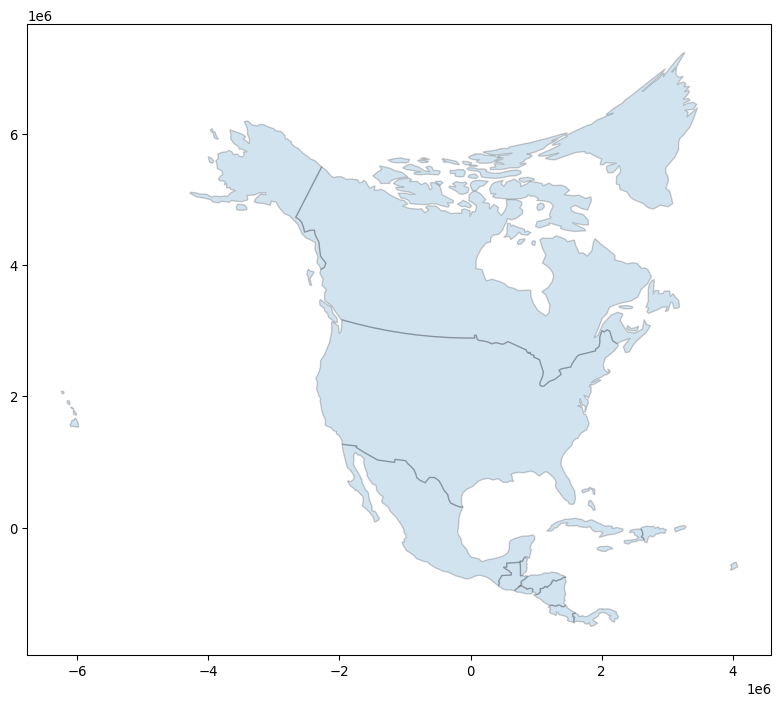

In [36]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig,ax = plt.subplots(figsize=(10, 10))
world[world.continent == "North America"].to_crs(5070).plot(alpha = 0.2, edgecolor = "k", ax = ax)
ax

<Figure size 672x480 with 0 Axes>

# Joindre des données

## Joindre des données sur des attributs

Ce type de jointure se fait entre un objet géographique et un
deuxième objet, géographique ou non. A l’exception de la question
des géométries, il n’y a pas de différence par rapport à `pandas`.

La seule différence avec `pandas` est dans la dimension géographique.
Si on désire conserver la dimension géographique, il faut faire
attention à faire :

``` python
geopandas_object.merge(pandas_object)
```

Si on utilise deux objets géographiques mais ne désire conserver qu’une seule
dimension géographique<a name="cite_ref-1"></a>[<sup>\[1\]</sup>](#cite_note-1), on fera

``` python
geopandas_object1.merge(geopandas_object2)
```

Seule la géométrie de l’objet de gauche
sera conservée, même si on fait un *right join*.

Il est techniquement possible d’avoir un DataFrame comportant plusieurs
géographies. Par exemple une géométrie polygone et une géométrie point
(le centroid). C’est néanmoins souvent compliqué à gérer et donc peu
recommandable.

## Prolongation possible : joindre des données sur dimension géographique

<div class="alert alert-warning" role="alert">

Les jointures spatiales peuvent être très gourmandes en ressources (car il peut être nécessaire de croiser toutes les géométries de `x` avec toutes les géométries de `y`). Voici deux conseils qui peuvent vous aider :

-   Il est préférable de tester les jointures géographiques sur un petit échantillon de données, pour estimer le temps et les ressources nécessaires à la réalisation de la jointure.
-   Il est parfois possible d’écrire une fonction qui réduit la taille du problème. Exemple: vous voulez déterminer dans quelle commune se situe un logement dont vous connaissez les coordonnées et le département; vous pouvez écrire une fonction qui réalise pour chaque département une jointure spatiale entre les logements situés dans ce département et les communes de ce département, puis empiler les 101 tables de sorties.

</div>

## Annexe

### Récupération des données depuis le package `pynsee`

Pour connaître les contraintes d’installation du package `pynsee`, se référer à la partie de cours dédiée à `pandas`.

In [38]:
#le téléchargement des données prend plusieurs minutes
from pynsee.geodata import get_geodata
shp_communes = gpd.GeoDataFrame(
  get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')
)
shp_communes = shp_communes.rename({"insee_com": 'insee'}, axis = 'columns')
#shp_communes = shp_communes.set_crs(3857)